In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

import os

In [2]:
df = pd.read_csv("BBC News Train.csv")
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
df['category_id'] = df['Category'].factorize()[0]

df['category_id'][0:10]
df.head(20)

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
5,1582,howard truanted to play snooker conservative...,politics,2
6,651,wales silent on grand slam talk rhys williams ...,sport,3
7,1797,french honour for director parker british film...,entertainment,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4


In [4]:
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df


,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [5]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category


{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [6]:
category_to_id

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [7]:
df.groupby('Category').category_id.count()


Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: category_id, dtype: int64

<AxesSubplot:xlabel='Category'>

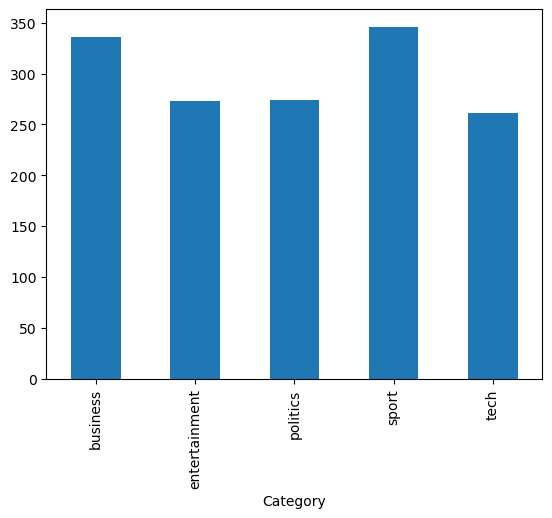

In [8]:
df.groupby('Category').category_id.count().plot.bar(ylim=0)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Text).toarray()
                                                 

labels = df.category_id                           


In [11]:
features.shape 


(1490, 9927)

In [12]:
category_to_id.items()


dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

In [13]:
sorted(category_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [15]:
from sklearn.feature_selection import chi2
N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   
  indices = np.argsort(features_chi2[0])                                  
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2] 
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [16]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

In [17]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 
projected_features.shape


(447, 2)

In [18]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values]


array([[ 18.101728  ,   4.5712643 ],
       [ 26.48669   ,   9.533953  ],
       [ 26.63272   ,  -9.640136  ],
       [ 20.318165  ,  13.158987  ],
       [ 21.914106  , -20.156086  ],
       [ 20.058659  ,   8.728493  ],
       [ 32.699257  ,  -6.165324  ],
       [ 18.229673  ,   9.955095  ],
       [ 12.626404  ,   5.612022  ],
       [ 17.627333  ,  17.45184   ],
       [  2.9628708 , -16.677534  ],
       [ 29.38238   ,   6.426106  ],
       [ 12.556033  ,   1.3322779 ],
       [ 24.287685  ,  -4.2993393 ],
       [ 22.129093  ,  15.18762   ],
       [ 29.66051   ,   8.599653  ],
       [ 26.51846   ,  10.898025  ],
       [ 20.745293  ,  10.475088  ],
       [ 23.864962  ,   3.6222327 ],
       [ 32.817474  ,  -2.8296046 ],
       [  5.841344  ,  10.715975  ],
       [ 22.37102   ,   0.5311744 ],
       [ 26.30639   ,  -9.3033085 ],
       [ 28.26359   ,  11.384173  ],
       [ 22.873184  ,   9.469372  ],
       [ 29.310429  ,  -0.5231528 ],
       [ 24.460054  ,   1.3506694 ],
 

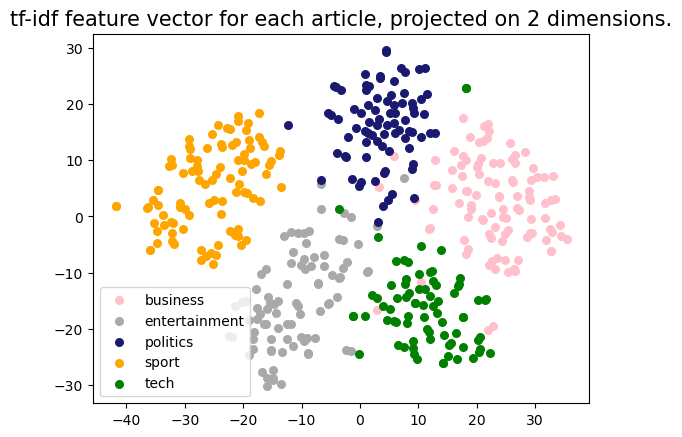

In [19]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=100, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=30),
]


In [21]:
CV = 5 

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] 


In [22]:

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))


In [23]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


<AxesSubplot:xlabel='model_name', ylabel='accuracy'>

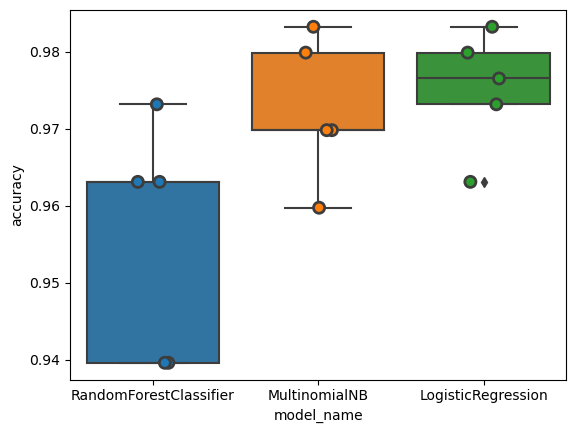

In [24]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)


In [25]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LogisticRegression        0.975168
MultinomialNB             0.972483
RandomForestClassifier    0.955705
Name: accuracy, dtype: float64

In [26]:
cv_df


,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.939597
1,RandomForestClassifier,1,0.939597
2,RandomForestClassifier,2,0.973154
3,RandomForestClassifier,3,0.963087
4,RandomForestClassifier,4,0.963087
5,MultinomialNB,0,0.969799
6,MultinomialNB,1,0.959732
7,MultinomialNB,2,0.983221
8,MultinomialNB,3,0.979866
9,MultinomialNB,4,0.969799


In [27]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=42)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


Text(0.5, 23.52222222222222, 'Predicted')

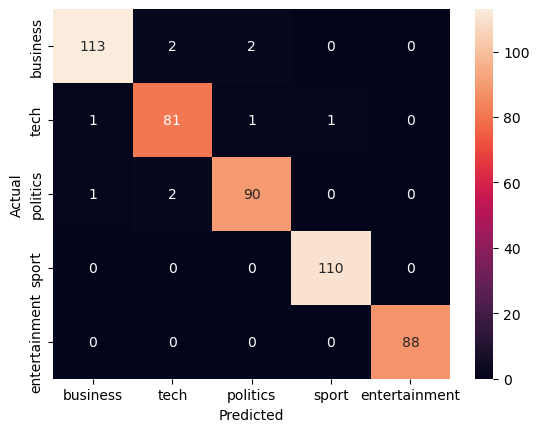

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [29]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
      print('')


'business' predicted as 'tech' : 2 examples.


1384    brussels raps mobile call charges the european...
664     orange colour clash set for court a row over t...
Name: Text, dtype: object


'politics' predicted as 'tech' : 2 examples.


1415    mps issued with blackberry threat mps will be ...
643     mps issued with blackberry threat mps will be ...
Name: Text, dtype: object


'business' predicted as 'politics' : 2 examples.


1309    saudi ministry to employ women women will be e...
691     salary scandal in cameroon cameroon says wides...
Name: Text, dtype: object

In [31]:
from sklearn.feature_selection import chi2

N = 5
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])   # This time using the model co-eficients / weights
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'business':
  . Top unigrams:
       . firm
       . bank
       . shares
       . company
       . market
  . Top bigrams:
       . chief executive
       . stock market
       . economic growth
       . analysts said
       . stock exchange
# 'entertainment':
  . Top unigrams:
       . film
       . band
       . music
       . singer
       . actor
  . Top bigrams:
       . box office
       . los angeles
       . big brother
       . film maker
       . named best
# 'politics':
  . Top unigrams:
       . labour
       . election
       . government
       . mr
       . blair
  . Top bigrams:
       . mr blair
       . prime minister
       . general election
       . tony blair
       . mr brown
# 'sport':
  . Top unigrams:
       . win
       . match
       . game
       . coach
       . season
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . grand slam
       . world number
# 'tech':
  . Top unigrams:
       . computer
       . soft

In [32]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest data in tech analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")


"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest data in tech analysis is!"
  - Predicted as: 'tech'

